In [1]:
import sys

import sklearn
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

c:\users\aleksandar stanev\appdata\local\programs\python\python37-32\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
train = pd.read_csv('data/house-prices/train.csv', index_col=['Id'])
test = pd.read_csv('data/house-prices/test.csv', index_col=['Id'])

In [3]:
print('train:', train.shape)
print('test:', test.shape)

train: (1460, 80)
test: (1459, 79)


In [4]:
train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Feature engineering

### Target variable

Това, което ще предсказваме е SalePrice. Нека я разгледаме.

c:\users\aleksandar stanev\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 180921.20 and sigma = 79415.29



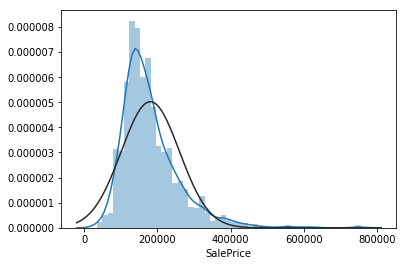

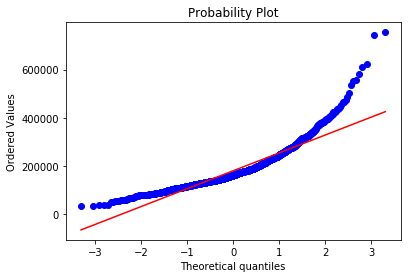

In [5]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

def check_skewness(col):
    sns.distplot(train[col] , fit=norm);
    fig = plt.figure()
    res = stats.probplot(train[col], plot=plt)
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(train[col])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    
check_skewness('SalePrice')


 mu = 12.02 and sigma = 0.40



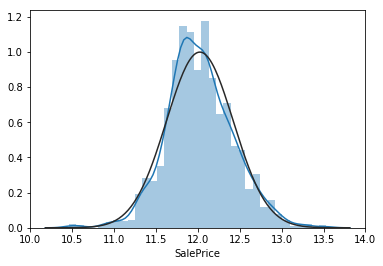

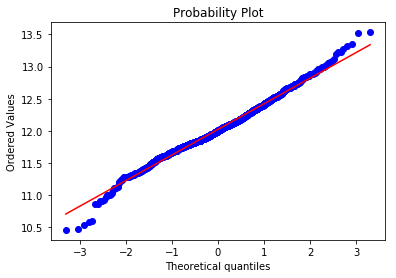

In [6]:
train["SalePrice"] = np.log1p(train["SalePrice"])

check_skewness('SalePrice')

Вече изглежда доста по-добре.

### Dealing with outliers

Според документацията, има единични случаи на къщи с доста големи различия на цена/площ спрямо останалите(outliers). Нека ги видим.

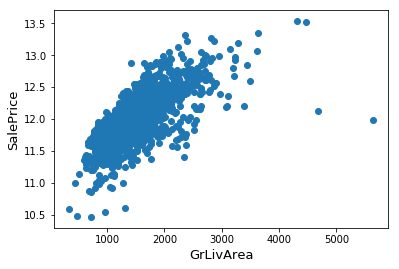

In [7]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

Виждаме, че долу в дясно има два случая на къщи с доста голяма GrLivArea, но с ниска цена. Тези стойности се различават изключително много от всички останали и биха объркали модела ни, затова ще ги премахнем.

In [8]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

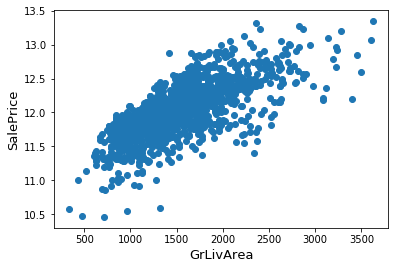

In [9]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

### Add features

Ще добавим общата квадратура на къщата като нов feature.

In [10]:
train['TotalSF'] = (
    train['BsmtFinSF1'].fillna(0) +
    train['BsmtFinSF2'].fillna(0) +
    train['1stFlrSF'].fillna(0) +
    train['2ndFlrSF'].fillna(0)
)

In [11]:
train.TotalSF.head()

Id
1    2416
2    2240
3    2272
4    1933
5    2853
Name: TotalSF, dtype: int64

In [12]:
sale_price_log = np.log(train.SalePrice)

### Missing data

Нека да видим кои стойности липсват.

In [13]:
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :train_na})
missing_data

,Missing Ratio
PoolQC,99.656593
MiscFeature,96.291209
Alley,93.750000
Fence,80.769231
FireplaceQu,47.390110
LotFrontage,17.788462
GarageYrBlt,5.563187
GarageType,5.563187
GarageFinish,5.563187
GarageQual,5.563187


Нека и да го визуализираме.

Text(0.5, 1.0, 'Percent missing data by feature')

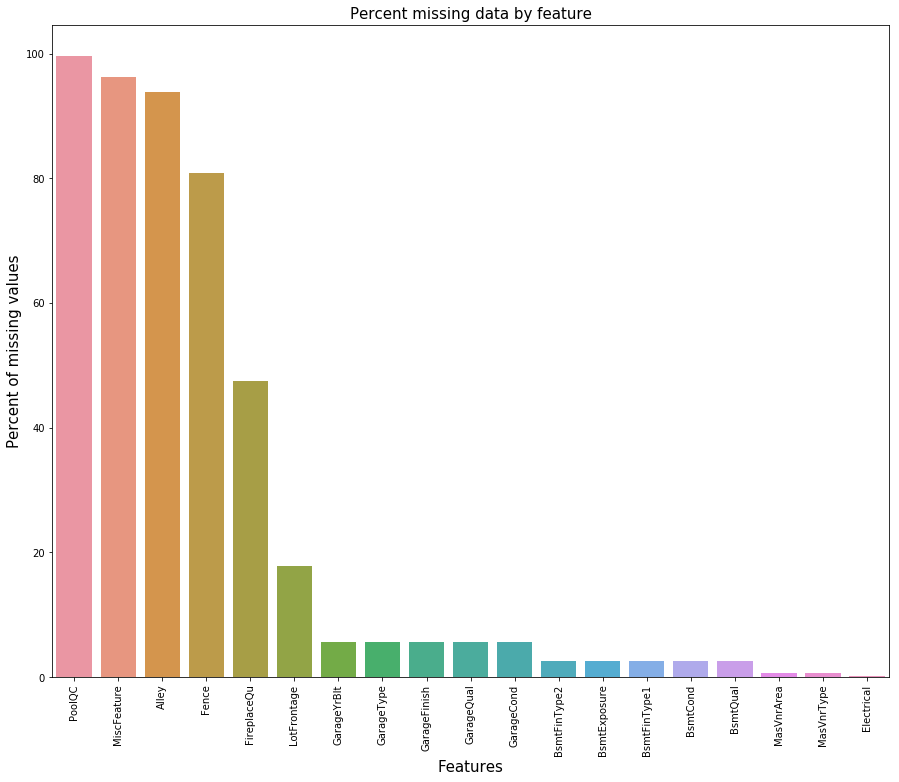

In [14]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=train_na.index, y=train_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

Ще попълним липсващите стойности с що-горе подходящи такива.

<b>PoolQC</b>, <b>MiscFeature</b>, <b>Alley</b>, <b>Fence</b> и <b>FireplaceQu</b>: За тези featur-и ще предположим, че липсата на стойност означава липса на съответния feature и ще ги попълним с "None".

In [15]:
train["PoolQC"] = train["PoolQC"].fillna("None")
train["MiscFeature"] = train["MiscFeature"].fillna("None")
train["Alley"] = train["Alley"].fillna("None")
train["Fence"] = train["Fence"].fillna("None")
train["FireplaceQu"] = train["FireplaceQu"].fillna("None")

<b>LotFrontage</b>: Тъй като площта на улицата до къщата най-вероятно има подобна площ на тази на другите къщи в квартала, ще използваме медианaта на LotFrontage от къщите в същия квартал.

In [16]:
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

<b>GarageType</b>, <b>GarageFinish</b>, <b>GarageQual</b> и <b>GarageCond</b>: Предполагаме, че в щом липсват стойности означава, че гараж липсва и ги попълваме с "None".

In [17]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    train[col] = train[col].fillna('None')

<b>GarageYrBlt</b>, <b>GarageArea</b> и <b>GarageCars</b>: Попълваме липсващите данни с 0 по същата причина.

In [18]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    train[col] = train[col].fillna(0)

<b>BsmtFinSF1</b>, <b>BsmtFinSF2</b>, <b>BsmtUnfSF</b>, <b>TotalBsmtSF</b>, <b>BsmtFullBath</b> и <b>BsmtHalfBath</b>: Попълваме ги с 0, защото предполагаме, че в тези случаи маза липсва.

In [19]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    train[col] = train[col].fillna(0)

<b>BsmtQual</b>, <b>BsmtCond</b>, <b>BsmtExposure</b>, <b>BsmtFinType1</b> and <b>BsmtFinType2</b>: Аналогично ги попълваме с "None".

In [20]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train[col] = train[col].fillna('None')

Попълваме и останалите липсващи данни с някакви подходящи стойности.

In [21]:
train["MasVnrType"] = train["MasVnrType"].fillna("None")
train["MasVnrArea"] = train["MasVnrArea"].fillna(0)
train['MSSubClass'] = train['MSSubClass'].fillna("None")
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])

Проверяваме отново дали има липсващи данни.

In [22]:
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :train_na})
missing_data

,Missing Ratio


Супер, нищо не липсва.

### Trying linear regression on the numeric columns only

След като попълнихме всички липсващи стойности, ще пробваме пуснем линейна регресия само върху  числовите данни, за да имаме отправна точка.

In [23]:
from sklearn.model_selection import train_test_split

train_no_sale_price = train.drop(labels=['SalePrice'], axis=1)
train_sale_price = train['SalePrice']

x_train, x_test, y_train, y_test = train_test_split(train_no_sale_price, 
                                                    train_sale_price, 
                                                    test_size=0.3, 
                                                    random_state=4330)

In [24]:
numeric_column_names = x_train.describe().columns

In [25]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(x_train[numeric_column_names], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [26]:
print("Train: ", regressor.score(x_train[numeric_column_names], y_train))
print("Test: ", regressor.score(x_test[numeric_column_names], y_test))

Train:  0.9024889614636202
Test:  0.8927649250495939


Да продължаваме с feature engineering-а.

### Transforming some numerical variables that are really categorical

In [27]:
train['MSSubClass'].value_counts()

20     536
60     295
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

Както виждаме, при някои feature-и категориите са преставени чрез числа. Тъй като реално показват категории, ще ги направим на string-ове.

In [28]:
train['MSSubClass'] = train['MSSubClass'].apply(str)

#train['YrSold'] = train['YrSold'].astype(str)
train['MoSold'] = train['MoSold'].astype(str)

Пробвах и с други, но само с тези се подобри резултата.

Ще разделим feature-ите на categorical и numerical 

In [29]:
categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns

train_numerical = train[numerical_features]
train_categorical = train[categorical_features]

### Fixing skewness

Ще прекараме числовите стойности през логаритъм, за да имат по-стандартна девиация.

In [30]:
from scipy.stats import skew

skewness = train_numerical.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]

In [31]:
skewed_features = skewness.index
pd.options.mode.chained_assignment = None
train_numerical[skewed_features] = np.log1p(train_numerical[skewed_features])

### One Hot Encoder

На категорийните feature-и ще приложим One Hot Encoder.

In [32]:
train_categorical.shape

(1456, 45)

In [33]:
train_categorical = pd.get_dummies(train_categorical)

In [34]:
train_categorical.shape

(1456, 292)

Последно, конкатенираме числовите и категорийните feature-и.

In [35]:
train = pd.concat([train_numerical, train_categorical], axis = 1)

### Trying different models

Първо ще пробваме отново линейна регресия.

In [36]:
train_no_sale_price = train.drop(labels=['SalePrice'], axis=1)
train_sale_price = train['SalePrice']

x_train, x_test, y_train, y_test = train_test_split(train_no_sale_price, 
                                                    train_sale_price, 
                                                    test_size=0.2, 
                                                    random_state=4330)

In [37]:
regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [38]:
print("Train: ", regressor.score(x_train, y_train))
print("Test: ", regressor.score(x_test, y_test))

Train:  0.9514757824934161
Test:  0.8398686185977877


Вижда се стабилен overfit, ще се опитаме да го оправим с регуляризация.

Нека пробваме Lasso.

In [39]:
from sklearn.linear_model import Lasso

alpha = [0.0005, 0.001, 0.01, 0.1, 1, 10, 100]

for a in alpha:
    all_data_lr = Lasso(alpha = a).fit(x_train, y_train)
    print('alpha:', a)
    print(all_data_lr.score(x_train, y_train), all_data_lr.score(x_test, y_test))
    print()

alpha: 0.0005
0.9369662748058185 0.9395507179503594

alpha: 0.001
0.9298324581978101 0.9363969284223471

alpha: 0.01
0.8601962435551076 0.882971908957606

alpha: 0.1
0.7404080997336175 0.7493009001887714

alpha: 1
0.646454950163915 0.6449142017678458

alpha: 10
0.558394142431709 0.5661768312090489

alpha: 100
0.05859290383998794 0.055232906711197294



При alpha = 0.0005 резултата изглежда обещаващ.

Да пробваме и Ridge.

In [40]:
from sklearn.linear_model import Ridge

alpha = [0.01, 0.1, 1, 10, 100]

for a in alpha:
    all_data_lr = Ridge(alpha = a).fit(x_train, y_train)
    print('alpha:', a)
    print(all_data_lr.score(x_train, y_train), all_data_lr.score(x_test, y_test))
    print()

alpha: 0.01
0.9511350896063561 0.909257463825439

alpha: 0.1
0.9503188118951007 0.919293246094661

alpha: 1
0.9482159819382385 0.9329923715743854

alpha: 10
0.9404087858773182 0.9364201513605033

alpha: 100
0.9155144013821921 0.9190718562940029



Тук виждаме малко по-слаби резултати.

В крайна сметка с Lasso с alpha: 0.0005 получаваме най-добри резултати:<br>
alpha: 0.0005<br>
0.9369662748058185<br>
0.9395507179503594